In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.3 MB/s eta 0:00:00


## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/3차 프로젝트_Early Bird팀/[참고자료] 문장 유형 분류 AI 경진대회/open'
mypath = '/content/drive/MyDrive/3차 프로젝트_Early Bird팀/은아/'

In [ ]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer # baseline code용 tfidef vectorirzer(또는 tokenizer)
from sklearn import preprocessing
from sklearn.metrics import f1_score

from transformers import AutoModel, AutoTokenizer  # 사용하고자 하는 모델, 토크나이저 적용시 필요
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm # process bar 표시용

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device  # pt 코드에서 필요함

device(type='cuda')

## Hyperparameter Setting

In [ ]:
CFG = {
    'EPOCHS':4,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,  # 커질수록 속도 빨라짐(GPU활용 극대화),32 64 정도 추천한다고 함(다른 의견도 있음)
    'SEED':41
}

## Fixed RandomSeed

https://tempdev.tistory.com/28

https://pytorch.org/docs/stable/notes/randomness.html


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False 
    torch.backends.cudnn.benchmark = True  
    # torch.use_deterministic_algorithms(True)

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
df = pd.read_csv(path+'/train.csv')
test = pd.read_csv(path+'/test.csv')

## Train / Validation Split

In [ ]:
# 제공된 학습데이터를 학습 / 검증 데이터셋으로 재 분할

''' stratified수행시 좋아질 수 있음 
    k-fold로 변형 필요 '''

train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

## Data Pre-processing
### 1. 문장(Text) 벡터화
### 2. Label Encoding (유형, 극성, 시제, 확실성)

## KLUE-PLMs(pretrained language models) 
We have trained 2 models: KLUE-BERT and KLUE-RoBERTa. <br>

| Model                | Embedding size | Hidden size | # Layers | # Heads |
|----------------------|----------------|-------------|----------|---------|
| KLUE-BERT-base            | 768            | 768         | 12       | 12      |
|                           |                |             |          |         |
| KLUE-RoBERTa-small        | 768            | 768         | 6        | 12      |
| KLUE-RoBERTa-base         | 768            | 768         | 12       | 12      |
| KLUE-RoBERTa-large        | 1024           | 1024        | 24       | 16      |

`NOTE`:  All the pretrained models are uploaded in Huggingface Model Hub. Check https://huggingface.co/klue.



In [ ]:
# # 1. 문장(Text) 벡터화 -> TfidfVectorizer
# vectorizer = TfidfVectorizer(min_df = 4, analyzer = 'word', ngram_range=(1, 2))  # 최소한 단어가 4번은 나온거 이상만 사용, unigrams + bigrams
# vectorizer.fit(np.array(train["문장"]))

# train_vec = vectorizer.transform(train["문장"])
# val_vec = vectorizer.transform(val["문장"])
# test_vec = vectorizer.transform(test["문장"])

# print(train_vec.shape, val_vec.shape, test_vec.shape)   
# # 9351 차원의 벡터로 특성 표현



'''https://huggingface.co/models
여기서 모델 검색후 적용, AutoModel, AutoTokenizer로 적용가능
BERT계열은 적용가능
monologg/kobigbird-bert-base
klue/roberta-base
klue/roberta-large
klue/roberta-small

GPT 계열은 embedding방식이 달라서 코드 변형 필요한듯
'skt/kogpt2-base-v2'
'''

pretrained_model = 'klue/roberta-small' 

base_model = AutoModel.from_pretrained(pretrained_model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [ ]:
# tokenizer 확인 및 테스트
# 허깅페이스 주석에 따르면 bert tokenizer랑 같은것 같음
# https://huggingface.co/klue
# https://github.com/KLUE-benchmark/KLUE
# NOTE: Use BertTokenizer instead of RobertaTokenizer. (AutoTokenizer will load BertTokenizer)
tokenizer("힛걸 진심 최고로 멋지다.", "힛걸 진심 최고다 그 어떤 히어로보다 멋지다")

{'input_ids': [0, 3, 7254, 3841, 2200, 11980, 2062, 18, 2, 3, 7254, 3841, 2062, 636, 3711, 12717, 2178, 2062, 11980, 2062, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.tokenize("힛걸 진심 최고로 멋지다.", "힛걸 진심 최고다 그 어떤 히어로보다 멋지다")

['[UNK]',
 '진심',
 '최고',
 '##로',
 '멋지',
 '##다',
 '.',
 '[UNK]',
 '진심',
 '최고',
 '##다',
 '그',
 '어떤',
 '히어로',
 '##보',
 '##다',
 '멋지',
 '##다']

In [ ]:
# 90개 token 으로 truncate하고 padding, pt는 pytorch 타입이라는 의미, tf로쓰면 tensorflow 타입으로 바꿀 수 있음
# 여기서 90개는 대략 표준분산 3배수로 짜른거 (EDA 참조), 3 sigma rule(68-95-99.7 rule)
# train_tokenized_texts = [tokenizer.tokenize(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in train["문장"]]
train_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in train["문장"]]
# NOTE: Use BertTokenizer instead of RobertaTokenizer. (AutoTokenizer will load BertTokenizer) 
# documentaion에 따르면 bertokenizer 쓰는거라고 함
# 기본(base/small) 모델 768차원, 라지(large) 모델 1024차원
# val_tokenized_texts = [tokenizer.tokenize(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt') for sent in val["문장"]]
val_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in val["문장"]]

In [ ]:
# tokenization 확인
print(len(train_tokenized_texts), len(val_tokenized_texts))
print(train_tokenized_texts[0])
print(len(train_tokenized_texts[0]))

13232 3309
{'input_ids': tensor([[    0, 19426,  2270,  3810,  2259,  1980,  4426,  2052,  9644,  2470,
          5518,  2200,  2112,  2259, 13691,  2028,  2252,  2069,  3905,  2085,
          1295,  1415,  2062,  1980,  1072,  5087,  2116,  8922,  4147,  8084,
          4034,  3986,  2371,  2062,    18,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [ ]:
# 2. Label Encoding (유형, 극성, 시제, 확실성) - 이거는 베이스라인 코드 써도 될듯
type_le = preprocessing.LabelEncoder()
train["유형"] = type_le.fit_transform(train["유형"].values)
val["유형"] = type_le.transform(val["유형"].values)
df["유형"] = type_le.transform(df["유형"].values)

polarity_le = preprocessing.LabelEncoder()
train["극성"] = polarity_le.fit_transform(train["극성"].values)
val["극성"] = polarity_le.transform(val["극성"].values)
df["극성"] = polarity_le.transform(df["극성"].values)

tense_le = preprocessing.LabelEncoder()
train["시제"] = tense_le.fit_transform(train["시제"].values)
val["시제"] = tense_le.transform(val["시제"].values)
df["시제"] = tense_le.transform(df["시제"].values)

certainty_le = preprocessing.LabelEncoder()
train["확실성"] = certainty_le.fit_transform(train["확실성"].values)
val["확실성"] = certainty_le.transform(val["확실성"].values)
df["확실성"] = certainty_le.transform(df["확실성"].values)




In [ ]:
train_type = train["유형"].values # sentence type
train_polarity = train["극성"].values # sentence polarity
train_tense = train["시제"].values # sentence tense
train_certainty = train["확실성"].values # sentence certainty

train_labels = {
    'type' : train_type,
    'polarity' : train_polarity,
    'tense' : train_tense,
    'certainty' : train_certainty
}

In [ ]:
val_type = val["유형"].values # sentence type
val_polarity = val["극성"].values # sentence polarity
val_tense = val["시제"].values # sentence tense
val_certainty = val["확실성"].values # sentence certainty

val_labels = {
    'type' : val_type,
    'polarity' : val_polarity,
    'tense' : val_tense,
    'certainty' : val_certainty
}

In [ ]:
df_type = df["유형"].values # sentence type
df_polarity = df["극성"].values # sentence polarity
df_tense = df["시제"].values # sentence tense
df_certainty = df["확실성"].values # sentence certainty

df_labels = {
    'type' : df_type,
    'polarity' : df_polarity,
    'tense' : df_tense,
    'certainty' : df_certainty
}

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_text, labels= None):
        self.texts = tokenized_text
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]

        if self.labels is not None:          
            st_type = self.labels['type'][index]
            st_polarity = self.labels['polarity'][index]
            st_tense = self.labels['tense'][index]
            st_certainty = self.labels['certainty'][index]

            return text, st_type, st_polarity, st_tense, st_certainty
        else:
            return text, torch.Tensor([-1,-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1])

In [ ]:
# train_data = TensorDataset(train_tokenized_texts, , train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
# validation_sampler = SequentialSampler(validation_data)
# validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


train_dataset = CustomDataset(train_tokenized_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_tokenized_texts, val_labels)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
train_dataset.texts[0]

{'input_ids': tensor([[    0, 19426,  2270,  3810,  2259,  1980,  4426,  2052,  9644,  2470,
          5518,  2200,  2112,  2259, 13691,  2028,  2252,  2069,  3905,  2085,
          1295,  1415,  2062,  1980,  1072,  5087,  2116,  8922,  4147,  8084,
          4034,  3986,  2371,  2062,    18,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0,

In [ ]:
train_dataset.labels['type'][0]

1

In [ ]:
len(train_dataset)
train_dataset[0]

({'input_ids': tensor([[    0, 19426,  2270,  3810,  2259,  1980,  4426,  2052,  9644,  2470,
           5518,  2200,  2112,  2259, 13691,  2028,  2252,  2069,  3905,  2085,
           1295,  1415,  2062,  1980,  1072,  5087,  2116,  8922,  4147,  8084,
           4034,  3986,  2371,  2062,    18,     2,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


## Model Define

In [ ]:
# # 테스트용

# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache() # gpu 자원관리   

# # model = AutoModelForSequenceClassification.from_pretrained('klue/roberta-small',num_labels = 3)
# # model.cuda()
# model = CustomModel()
# model.to(device)

# for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(train_loader)): # 각각의 train data iteration 

#     # sentence = sentence.to(device)
#     input_ids = sentence.input_ids.squeeze(1).to(device)
#     attention_mask = sentence.attention_mask.to(device)
#     a, b, c, d = model(input_ids=input_ids, attention_mask=attention_mask)
#     print(a)
#     # print(b)
#     # print(c)
#     # print(d)

#     break

In [ ]:
# model(train_dataset.texts[0].input_ids.to(device),train_dataset.texts[0].attention_mask.to(device))
# train_dataset.texts[0].input_ids.to(device)

In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # if model_path == 'monologg/kobigbird-bert-base':
        #     config.attention_type = "original_full"
        # self.base_model = AutoModel.from_pretrained(model_path, config=config)
        self.base_model = AutoModel.from_pretrained(pretrained_model).to(device)
        try:
            self.out = self.base_model.encoder.layer[-1].output.dense.out_features
        except:
            self.out = 768
        # self.linear = nn.Linear(768, 768//2)

        self.type_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=4),    # 유형 : 문장의 유형 (사실형, 추론형, 대화형, 예측형)
            # nn.Softmax(dim=1)
        )
        self.polarity_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=3), # 극성 : 문장의 극성 (긍정, 부정, 미정)
            # nn.Softmax(dim=1)
        )
        self.tense_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=3), # 시제 : 문장의 시제 (과거, 현재, 미래)
            # nn.Softmax(dim=1)            
        )
        self.certainty_classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.out, out_features=2), # 확실성 : 문장의 확실성 (확실, 불확실)
            # nn.Softmax(dim=1)            
        )
        
    def forward(self, input_ids, attention_mask, labels=None, token_type_ids=None):
        x = self.base_model(input_ids=input_ids, attention_mask=attention_mask)[0]

        # x = self.linear(x)
        # 문장 유형, 극성, 시제, 확실성을 각각 분류
        type_output = self.type_classifier(x[:,0,:].view(-1,self.out))
        polarity_output = self.polarity_classifier(x[:,0,:].view(-1,self.out))
        tense_output = self.tense_classifier(x[:,0,:].view(-1,self.out))
        certainty_output = self.certainty_classifier(x[:,0,:].view(-1,self.out))
        return type_output, polarity_output, tense_output, certainty_output

## Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }
    
    best_loss = 999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(train_loader)): # 각각의 train data iteration 
            
            # sentence = sentence.to(device)

            # attention_mask = train_input['attention_mask'].to(device)
            # input_ids = train_input['input_ids'].squeeze(1).to(device)
            
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)

            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            optimizer.zero_grad()  # 초기화

            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids,attention_mask)  # 모델 적용

            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)

            loss.backward()  # 역전파

            optimizer.step()  # 한단계 진행

            train_loss.append(loss.item()) # loss 합산

        val_loss, val_type_f1, val_polarity_f1, val_tense_f1, val_certainty_f1, f1_mult = validation(model, val_loader, criterion, device)

        print(f'Epoch : [{epoch}] F1 : [{f1_mult:.5f}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{val_type_f1:.5f}] 극성 F1 : [{val_polarity_f1:.5f}] 시제 F1 : [{val_tense_f1:.5f}] 확실성 F1 : [{val_certainty_f1:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            
    return best_model

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []
    
    
    with torch.no_grad():
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(val_loader)):

            # sentence = sentence.to(device)
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)
            
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids,attention_mask)
            
            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
            val_loss.append(loss.item())
          
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            type_labels += type_label.detach().cpu().numpy().tolist()
            
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_labels += polarity_label.detach().cpu().numpy().tolist()
            
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_labels += tense_label.detach().cpu().numpy().tolist()
            
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    
    type_f1 = f1_score(type_labels, type_preds, average='weighted')
    polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
    tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
    certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')

    f1_mult = type_f1 * polarity_f1 * tense_f1 * certainty_f1
    
    return np.mean(val_loss), type_f1, polarity_f1, tense_f1, certainty_f1, f1_mult

## Run!!

In [ ]:
import gc
# del model
gc.collect()
torch.cuda.empty_cache() # gpu 자원관리   

model = CustomModel()
model.to(device)

model.train()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [1] F1 : [0.70151] Train Loss : [0.33260] Val Loss : [0.21930] 유형 F1 : [0.88578] 극성 F1 : [0.97209] 시제 F1 : [0.88923] 확실성 F1 : [0.91619]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [2] F1 : [0.71022] Train Loss : [0.19511] Val Loss : [0.21014] 유형 F1 : [0.87892] 극성 F1 : [0.97396] 시제 F1 : [0.89727] 확실성 F1 : [0.92466]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [3] F1 : [0.70693] Train Loss : [0.15427] Val Loss : [0.22736] 유형 F1 : [0.87853] 극성 F1 : [0.97452] 시제 F1 : [0.89592] 확실성 F1 : [0.92165]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [4] F1 : [0.70806] Train Loss : [0.11383] Val Loss : [0.24409] 유형 F1 : [0.87397] 극성 F1 : [0.97507] 시제 F1 : [0.89705] 확실성 F1 : [0.92624]


# Model save

In [ ]:
model_name = pretrained_model.replace('/','-')
torch.save(infer_model, mypath+model_name+f"_BatchSize_{CFG['BATCH_SIZE']}_Epoch_{CFG['EPOCHS']}.pt")

## Inference

In [ ]:
# '/content/drive/MyDrive/3차 프로젝트_Early Bird팀/은아/small_Epoch_4.pt'

filepath =input()
model = torch.load(filepath)

/content/drive/MyDrive/3차 프로젝트_Early Bird팀/은아/klue-roberta-small_BatchSize_256_Epoch_4.pt


In [ ]:
test_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in test["문장"]]
test_dataset = CustomDataset(test_tokenized_texts,df_labels)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    
    with torch.no_grad():
        for sentence, _, _, _, _ in tqdm(test_loader):
            # sentence = sentence.to(device)
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)
                        
            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids, attention_mask)
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            
    return type_preds, polarity_preds, tense_preds, certainty_preds

In [ ]:
type_preds, polarity_preds, tense_preds, certainty_preds = inference(model, test_loader, device)

  0%|          | 0/7090 [00:00<?, ?it/s]

In [ ]:
len(type_preds)

7090

In [ ]:
type_preds[0]

1

In [ ]:
type_preds = type_le.inverse_transform(type_preds)
polarity_preds = polarity_le.inverse_transform(polarity_preds)
tense_preds = tense_le.inverse_transform(tense_preds)
certainty_preds = certainty_le.inverse_transform(certainty_preds)

In [ ]:
type_preds[0]

'사실형'

In [ ]:
predictions = []
for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

## Submission

In [ ]:
submit = pd.read_csv(path+'/sample_submission.csv')
submit['label'] = predictions

In [ ]:
# submit['문장']  = test.문장

In [ ]:
submit.head()

,ID,label
0,TEST_0000,사실형-긍정-현재-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실


In [ ]:
df.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,1,0,2,1,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,1,0,0,1,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,1,0,1,1,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",1,0,0,1,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,1,0,2,1,사실형-긍정-현재-확실


In [ ]:
model_name = pretrained_model.replace('/','-')
submit.to_csv(mypath+'제출용_'+model_name+f"_BatchSize_{CFG['BATCH_SIZE']}_Epoch_{CFG['EPOCHS']}.csv", index=False)

# 개별 문장에 적용해보기

In [ ]:
def inference_text(text) :

  type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []

  ts = tokenizer(test_text,padding='max_length', max_length=90, truncation=True, return_tensors='pt')
  type_logit, polarity_logit, tense_logit, certainty_logit =model(ts.input_ids.to(device), ts.attention_mask.to(device)) 

  type_preds = type_logit.argmax(1).detach().cpu().numpy().tolist()
  polarity_preds = polarity_logit.argmax(1).detach().cpu().numpy().tolist()
  tense_preds = tense_logit.argmax(1).detach().cpu().numpy().tolist()
  certainty_preds = certainty_logit.argmax(1).detach().cpu().numpy().tolist()

  type_preds = type_le.inverse_transform(type_preds)
  polarity_preds = polarity_le.inverse_transform(polarity_preds)
  tense_preds = tense_le.inverse_transform(tense_preds)
  certainty_preds = certainty_le.inverse_transform(certainty_preds)

  predictions = []
  for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

  return (predictions)

In [ ]:
test_text = "미술상, 편집상만 수상이 안됐다. "
# test_text = "26일 JTBC에 따르면 지난 20일 오후 4시 반쯤 강원도 고성의 한 대나무숲에서 태어난 지 3일에서 일주일 정도로 추정되는 신생아가 구조됐다. "
inference_text(test_text)

['사실형-부정-과거-확실']

# 오답 출력해보기

In [ ]:
review_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in df["문장"]]
review_dataset = CustomDataset(review_tokenized_texts, df_labels)
review_loader = DataLoader(review_dataset, shuffle=False, num_workers=0)

In [ ]:
def review_notes(model, review_loader, device):
    model.to(device)
    model.eval()
    
    review_note = pd.DataFrame(columns=('문장', '예측','정답'))
    type_preds_list, polarity_preds_list, tense_preds_list, certainty_preds_list = [], [], [], []
    type_labels_list, polarity_labels_list, tense_labels_list, certainty_labels_list = [], [], [], []
    
    i = 0

    with torch.no_grad():
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(review_loader):
            # sentence = sentence.to(device)
            input_ids = sentence.input_ids.squeeze(1).to(device)
            attention_mask = sentence.attention_mask.to(device)

            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)

            type_logit, polarity_logit, tense_logit, certainty_logit = model(input_ids, attention_mask)

            type_preds = type_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_preds = polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_preds = tense_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_preds = certainty_logit.argmax(1).detach().cpu().numpy().tolist()

            type_preds_list +=type_preds; polarity_preds_list+=polarity_preds; tense_preds_list+=tense_preds; certainty_preds_list+=certainty_preds;

            type_label = type_label.cpu().numpy().tolist()
            polarity_label = polarity_label.cpu().numpy().tolist()
            tense_label = tense_label.cpu().numpy().tolist()
            certainty_label = certainty_label.cpu().numpy().tolist()

            type_labels_list +=type_label; polarity_labels_list+=polarity_label; tense_labels_list+=tense_label; certainty_labels_list+=certainty_label;

            type_preds = type_le.inverse_transform(type_preds)
            polarity_preds = polarity_le.inverse_transform(polarity_preds)
            tense_preds = tense_le.inverse_transform(tense_preds)
            certainty_preds = certainty_le.inverse_transform(certainty_preds)

            type_label = type_le.inverse_transform(type_label)
            polarity_label = polarity_le.inverse_transform(polarity_label)
            tense_label = tense_le.inverse_transform(tense_label)
            certainty_label = certainty_le.inverse_transform(certainty_label)

            if (type_preds != type_label) or (polarity_preds != polarity_label) or (tense_preds != tense_label) or (certainty_preds != certainty_label) :
                                  
              predictions = []
              for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
                if(type_preds != type_label) :
                  predictions.append(type_pred)
                else :
                  predictions.append(" ")
                if(polarity_pred != polarity_label) :
                  predictions.append('-'+polarity_pred)
                else :
                  predictions.append("- ")
                if(tense_preds != tense_label) :
                  predictions.append('-'+tense_pred)
                else :
                  predictions.append("- ")                  
                if(certainty_preds != certainty_label) :
                  predictions.append('-'+certainty_pred)
                else :
                  predictions.append("- ")
              
              labels = []
              for type_label, polarity_label, tense_label, certainty_label in zip(type_label, polarity_label, tense_label, certainty_label):
                labels.append(type_label+'-'+polarity_label+'-'+tense_label+'-'+certainty_label)
              
              review_note = review_note.append({'문장':tokenizer.decode(input_ids[0]),'예측': predictions, '정답':labels},ignore_index=True)
              # print(tokenizer.decode(input_ids[0]), predictions, labels)

    # None으로 두면 각각의 F1 스코어를 볼 수 있음          
    type_f1 = f1_score(type_labels_list, type_preds_list, average=None)
    polarity_f1 = f1_score(polarity_labels_list, polarity_preds_list, average=None)
    tense_f1 = f1_score(tense_labels_list, tense_preds_list, average=None)
    certainty_f1 = f1_score(certainty_labels_list, certainty_preds_list, average=None)

    # label인코더 순서대로 리스팅
    type_list = ['대화형','사실형', '예측형','추론형']
    polarity_list = ['긍정', '미정', '부정']
    tense_list = ['과거', '미래', '현재']
    certainty_list = ['불확실', '확실']

    for pair in zip(type_list,type_f1) :
      print (pair)
      review_note = review_note.append({'문장':str(pair),'예측': '', '정답':''},ignore_index=True)
    for pair in zip(polarity_list,polarity_f1) :
      print (pair)
      review_note = review_note.append({'문장':str(pair),'예측': '', '정답':''},ignore_index=True)
    for pair in zip(tense_list,tense_f1) :
      print (pair)
      review_note = review_note.append({'문장':str(pair),'예측': '', '정답':''},ignore_index=True)
    for pair in zip(certainty_list,certainty_f1) :
      print (pair)
      review_note = review_note.append({'문장':str(pair),'예측': '', '정답':''},ignore_index=True)
                
    return review_note

In [ ]:
review_note = review_notes(model, review_loader, device)

  0%|          | 0/16541 [00:00<?, ?it/s]

('대화형', 0.9860383944153577)
('사실형', 0.9788998568859859)
('예측형', 0.7827868852459016)
('추론형', 0.8768167738861091)
('긍정', 0.9934937780304467)
('미정', 0.5392491467576791)
('부정', 0.9316770186335404)
('과거', 0.9829372712043185)
('미래', 0.8782913984786425)
('현재', 0.9538643242046209)
('불확실', 0.727120768909319)
('확실', 0.9787220176610513)


- 데이터가 적은 쪽이 F1 Score가 낮게 나옴
- 데이터 Augmentation or training data 보강 필요

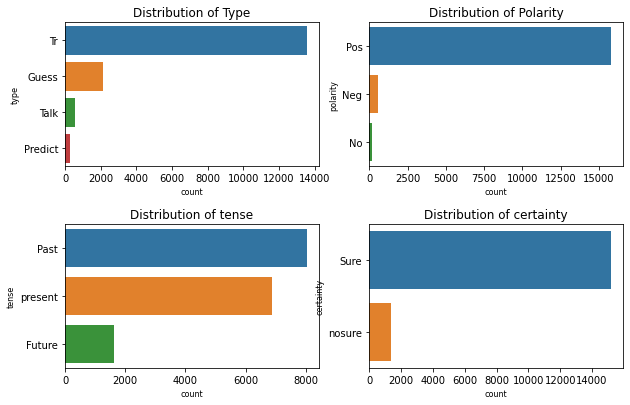

In [ ]:
review_note.to_csv(mypath+'오답노트_'+model_name+f"_BatchSize_{CFG['BATCH_SIZE']}_Epoch_{CFG['EPOCHS']}.csv", index=False, encoding = 'euc-kr')